In [1]:
import numpy as np
import scipy.sparse as sp
from IPython.display import Image
import matplotlib.pyplot as plt

In [2]:
Image(url= "../algo.png", width=500)

In [3]:
## Hyperparams and metadata

N_ITERS = 10
DAMPING = 0.9
NODES = 196591
EDGES = 950327
FULL_EDGES = 2097245
DTYPE = np.float32

Adj. matrix 196591 x 196591


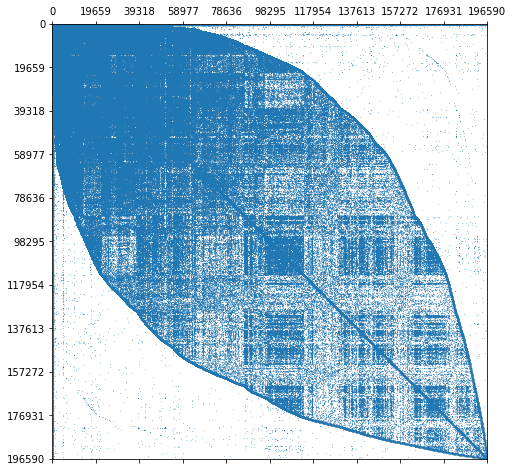

In [4]:
## Load data

adj_mat_path = '../Dataset/adj_mat.npz' # sparse adjacency matrix
s_mat = sp.load_npz(adj_mat_path)
s_mat = sp.lil_matrix(s_mat, dtype=DTYPE) # make LIL matrix once in order to eventually change sparsity 
print('Adj. matrix %i x %i' % (s_mat.shape[0], s_mat.shape[1]))

# visualize
plt.figure(figsize=(8, 8))
plt.spy(s_mat, markersize=0.1)
plt.xticks(np.arange(0, NODES, NODES // 10))
plt.yticks(np.arange(0, NODES, NODES // 10))
plt.show()

In [5]:
## Update R

# R <- S - maxx(S + A) = S - maxx(V) = S - M, where maxx is max_{j: j \neq k}
def update_r(s_mat, a_mat, r_old, damping):
    
    # calculate V
    stab_mat = sp.lil_matrix((NODES, NODES), dtype=DTYPE)
    stab_mat[s_keys[0], s_keys[1]] = 10000. # for numerical stability
    v_mat = a_mat.tocsr() + s_mat.tocsr() + stab_mat.tocsr()
    v_mat.eliminate_zeros()
    
    # auxiliary stuff
    dtype_min = -np.inf # change if DTYPE is int
    rows_arr = np.arange(0, NODES)
    
    # calculate maxima args
    first_maxima_args = np.asarray(v_mat.argmax(axis=1)).flatten()
    v_mat_copy = sp.lil_matrix(v_mat, dtype=DTYPE)
    v_mat_copy[rows_arr, first_maxima_args] = dtype_min 
    second_maxima_args = np.asarray(v_mat_copy.tocsr().argmax(axis=1)).flatten()
    
    # rearrange first max values in a way they place nicely inside M 
    first_maxima_full = np.asarray(v_mat[rows_arr, first_maxima_args]).flatten()[s_keys[0]]
    
    # fill M with first maxima
    m_mat = sp.lil_matrix((NODES, NODES), dtype=DTYPE)
    m_mat[s_keys[0], s_keys[1]] = first_maxima_full # first maxima only
    
    # fill M with second maxima
    second_maxima_full = np.asarray(v_mat[rows_arr, second_maxima_args]).flatten()
    m_mat[rows_arr, first_maxima_args] = second_maxima_full
    
    # replace zeros in second_maxima_full with -np.inf, since they are from the placces where there are no edges
    #second_maxima_full[np.argwhere(second_maxima_full == 0.)] = -np.inf
    
    # mask by S' nonzero elements
    m_mat_masked = sp.lil_matrix((NODES, NODES), dtype=DTYPE)
    m_mat_masked[s_keys[0], s_keys[1]] = m_mat[s_keys[0], s_keys[1]]
    
    # clean from unnecessary zeros
    m_mat_masked = m_mat_masked.tocsr()
    m_mat_masked = m_mat_masked - stab_mat.tocsr()
    m_mat_masked.eliminate_zeros()
    
    # update R
    r_mat = s_mat.tocsr() - m_mat_masked 
    
    print('R max %.2f' % r_mat.max())
    print('R min %.2f' % r_mat.min())
    
    # apply damping
    r_mat = damping * r_old + (1. - damping) * r_mat

    return r_mat

In [24]:
## Update A

# A(i, k) <- min{0, R(k, k) + sum_{j: j \neq i, j \neq k} max{0, R(j, k)}} 
# A(k, k) <- sum_{j: j \neq k} max{0, R(j, k)}
def update_a(r_mat, a_old, damping):
    
    # aux.
    nodes_arr = np.arange(0, NODES)
    r_diag = r_mat.diagonal()
    
    # clean R from negative elements
    r_pos = sp.lil_matrix(r_mat, dtype=DTYPE)
    r_pos[r_pos < 0] = 0
    r_pos = r_pos.tocsr()
    r_pos.eliminate_zeros()
    
    # for now, just calculate a sum over all rows...
    r_pos_sum = np.asarray(r_pos.sum(axis=0)).flatten()
    
    # rearrange sum values and place them inside a
    aa_mat = sp.lil_matrix((NODES, NODES), dtype=DTYPE)
    r_pos_sum_full = r_pos_sum[s_keys[1]]
    aa_mat[s_keys[0], s_keys[1]] = r_pos_sum_full
    aa_mat = aa_mat.tocsr()
    
    # subtract where j = i
    aa_mat = aa_mat - r_pos
    
    # subtract where j = k (ignore the i = k collision, because A(k, k) is calculated separately)
    r_pos_diag = r_pos.diagonal()
    r_pos_diag_full = r_pos_diag[s_keys[1]]
    bb_mat = sp.lil_matrix((NODES, NODES), dtype=DTYPE)
    bb_mat[s_keys[0], s_keys[1]] = r_pos_diag_full 
    aa_mat = aa_mat - bb_mat.tocsr()
    
    # add R(k, k)
    r_diag_full = r_diag[s_keys[1]]
    bb_mat[s_keys[0], s_keys[1]] = r_diag_full
    aa_mat = aa_mat + bb_mat
    
    a_mat = sp.lil_matrix(aa_mat)
    a_mat[a_mat > 0] = 0
    
    # calulate A(k, k)
    akk = r_pos_sum - r_pos_diag
    a_mat[nodes_arr, nodes_arr] = akk
    
    # as usual, get rid of unnecessary zeros
    a_mat = a_mat.tocsr()
    a_mat.eliminate_zeros()
    
    print('A max %.2f' % a_mat.max())
    print('A min %.2f' % a_mat.min())
    
    # apply damping
    a_mat = damping * a_old + (1 - damping) * a_mat
   
    return a_mat

In [25]:
## S preprocessing

# find non-zero values of S
s_keys = np.concatenate((sp.find(s_mat)[0].reshape(1, -1),          # rows of non-zero values
                         sp.find(s_mat)[1].reshape(1, -1)), axis=0) # columns of non-zero values

# add a little randomness
random_vetor = np.random.rand(EDGES * 2)
s_mat_new = sp.lil_matrix((NODES, NODES), dtype=DTYPE)
s_mat_new[s_keys[0], s_keys[1]] = s_mat[s_keys[0], s_keys[1]] + random_vetor
#s_mat_new = s_mat

# set self-similarity values
self_sim = -1.5
s_mat_new.setdiag(self_sim)

# find them again...
s_keys = np.concatenate((sp.find(s_mat_new)[0].reshape(1, -1),          # rows of non-zero values
                         sp.find(s_mat_new)[1].reshape(1, -1)), axis=0) # columns of non-zero values

In [26]:
## AP iterations

# make A and R matrices (LIL for better manipulating the sparse structure)
a_mat = sp.lil_matrix((NODES, NODES), dtype=DTYPE)
r_mat = sp.lil_matrix((NODES, NODES), dtype=DTYPE)

# iterate
import time
start_time = time.time()
for ittt in range(N_ITERS):
    print('Iteration %i' % ittt)
    r_mat = update_r(s_mat_new, a_mat, r_mat, DAMPING)
    a_mat = update_a(r_mat, a_mat, DAMPING)
end_time = time.time()
solution_time = end_time - start_time
print('Solution time: %.2f seconds' % solution_time)

Iteration 0
R max 3.50
R min -3.50
A max 593.27
A min -0.35
Iteration 1
R max 3.50
R min -56.83
A max 1129.83
A min -0.66
Iteration 2
R max 3.50
R min -163.88
A max 1617.64
A min -0.95
Iteration 3
R max 3.50
R min -309.00
A max 2063.50
A min -1.20
Iteration 4
R max 3.50
R min -484.20
A max 2473.41
A min -1.43
Iteration 5
R max 3.50
R min -682.87
A max 2852.36
A min -1.64
Iteration 6
R max 3.50
R min -899.57
A max 3204.02
A min -1.83
Iteration 7
R max 3.50
R min -1129.77
A max 3532.37
A min -1.99
Iteration 8
R max 3.50
R min -1369.78
A max 3840.15
A min -2.14
Iteration 9
R max 3.50
R min -1616.57
A max 4128.86
A min -2.28
Solution time: 283.26 seconds


In [27]:
## Get exemplars

c_mat = a_mat + r_mat
exemp = np.asarray(c_mat.argmax(axis=1)).flatten() # array of exemplars for all users (0...NODES)
exemp_uniq = np.unique(exemp) # unique exemplars
print('Number of clusters: %i' % (exemp_uniq.shape[0]))

Number of clusters: 33456


In [28]:
## Transitive convolution

depth = 100
exemp_trans = exemp.copy()
for i in range(depth):
    exemp_trans[:] = exemp_trans[exemp_trans[:]]

exemp_trans_uniq = np.unique(exemp_trans)

print('Number of clusters: %i' % (exemp_trans_uniq.shape[0]))
np.save('./exemplars.npy', exemp_trans)

Number of clusters: 5337


In [30]:
print(sp.find(c_mat)[2].size)
sp.save_npz('./c_mat.npz', c_mat)

2097245
